## RNN : Recurrent Neural Networks

RNN are more similar to Feed Forward Neural Network than CNN.

Architecture of a traditional RNN ― Recurrent neural networks, also known as RNNs, are a class of neural networks that allow previous outputs to be used as inputs while having hidden states.

![Image](RNN_1.jpeg)

"https://karpathy.github.io/2015/05/21/rnn-effectiveness/"

In [1]:
# Read links :
from IPython.display import IFrame

IFrame(src="https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks", width=800, height=800)

## RNN with One hidden Layer
![Image](RNN_1.svg)

## RNN with Two hidden Layer
![image](RNN_2.svg)

### Model A : 1 Hidden Layer (Relu)

1. Unroll 28 time steps 
    - Each Step Input Size : 28 x 1
    - Total Per unroll : 28 x 28
    - 1 Hidden Layer 
    - Relu Activation Function

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [ ]:
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [ ]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
'''
STEP 3: CREATE MODEL CLASS
'''

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [ ]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER for 2 Hidden Dimensions
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

In [ ]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

In [ ]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [ ]:
'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
            
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss, accuracy))

### Layer_dim = 1 : The number of pramaeters we have is 6 : [A1,B1],[A2,B2],[A3,B3]

![Image](RNN_4.svg)

### Layer_dim = 2 : The number of pramaeters we have is 10 : [A1,B1],[A2,B2],[A3,B3][A4,B4][A5,B5]

![image](RNN_3.svg)

## Sequence Modeling 

In [6]:
from IPython.display import IFrame
display(IFrame("https://cs230.stanford.edu/files/C5M1.pdf", width=1200, height=800))

# LSTM : Long Short Term Memory Networks 

- Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. 
- They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.
- They work tremendously well on a large variety of problems, and are now widely used.
- The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.
- Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.
- Tanh squashes a real-valued number to the range [-1, 1].
- Sigmoid takes a real value as input and outputs another value between 0 and 1.
- tanh is just a rescaled and shifted sigmoid
- What is the intuition of using tanh in LSTM ? 
https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm?noredirect=1&lq=1
- How do we initialize C[0,:] and h[0,:]?

## Q&A of the colah blog :
You just initialize them with random numbers.
    - Once you unroll the graph, there's nothing special about training it. You just do gradient descent: http://colah.github.io/post...
- Why does the "sigmoid" function is used to indicate "which values we'll be updating", while the "tanh" function is used to indicate "what is the value of the new information"???
    - We use a sigmoid layer -- not just a sigmoid function, but a neural net layer with sigmoid activations -- to decide which values we update because it outputs values between 0 an 1. Multiplying by 0 blocks things, while multiplying by 1 lets it through.
    - We use a tanh layer for the new information because we want to be able to store both positive and negative values, 
    and tanh outputs values between -1 and 1.

- So it's a matter of the range of the output, and it's not related to the intricate non-linearity of each function.
    Theoretically-speaking, it would be similar to using a TANH layer for both gates, and normalizing the output to range between 0-1 only for the forget gate. Is that correct?   
    - Sigmoid and tanh are the same function, modulo the normalization. :)
    - tanh(x) = 2*sigmoid(2x) - 1
    
- I was slightly confused about one aspect of your explanation of LSTM cells: I was not aware, that the cell's state C_t is actually revealed to the next cell in the upcoming time-step. When I first learned about LSTM, I had the picture uploaded with this comment in mind, where the cell's state C_t is not part of the output (only implicitly through h_t), i.e. it is private to the cell. Is your LSTM cell thus another variant or has this sharing of cell states always been implied?
     - Great question! What I am presenting is the standard LSTM.
     - The diagram you've included is a rolled up way of presenting an LSTM: it represents every time step. 
     - Notice how C_t loops back into itself: that is where C_t gets passed from one time step to the next.
     - If the network didn't pass C_t to the next time step, 
         - it would be hard for it to use C_t to remember things for long periods of time, 
         - and the benefit of the LSTM would be lost.
     - I think we should generally prefer unrolled diagrams for this reason. 
     - Rolled up diagrams are often hard to interpret and ambiguous. 
     - I'd encourage you to work through the equations for an LSTM and see that they may to the diagrams included.

In [25]:
import pandas as pd
table = [["Update gate ΓuΓu","How much past should matter now?","GRU, LSTM"],
["Relevance gate ΓrΓr","Drop previous information?","GRU, LSTM"],
["Forget gate ΓfΓf","Erase a cell or not?","LSTM"],
["Output gate ΓoΓo","How much to reveal of a cell?","LSTM"]]

pd.DataFrame(table,columns=["Type of gate","Role","Used in"])

,Type of gate,Role,Used in
0,Update gate ΓuΓu,How much past should matter now?,"GRU, LSTM"
1,Relevance gate ΓrΓr,Drop previous information?,"GRU, LSTM"
2,Forget gate ΓfΓf,Erase a cell or not?,LSTM
3,Output gate ΓoΓo,How much to reveal of a cell?,LSTM


![Image](LSTM_GRU_1.png)

![Image](LSTM_GRU_2.png)

<img src="LSTM_2.svg" alt="Drawing" style="width: 1800px;"/>

In [9]:
from IPython.display import IFrame
IFrame("http://colah.github.io/posts/2015-08-Understanding-LSTMs/", width=1200, height=800)

In [11]:
from IPython.display import IFrame
IFrame("http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/", width=1200, height=800)


## Code of LSTM 

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [ ]:
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


In [ ]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################

        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # Initialize cell state
        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # One time step
        out, (hn, cn) = self.lstm(x, (h0,c0))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [ ]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

In [ ]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

In [ ]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

In [ ]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


In [ ]:
'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
            
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

In [26]:
from IPython.display import YouTubeVideo

def display_yotube_video(url, **kwargs):
    """
    Displays a Youtube video in a Jupyter notebook.
    
    Args:
        url (string): a link to a Youtube video.
        **kwargs: further arguments for IPython.display.YouTubeVideo
    
    Returns:
        YouTubeVideo: a video that is displayed in your notebook.
    """
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

## Word to  Vec

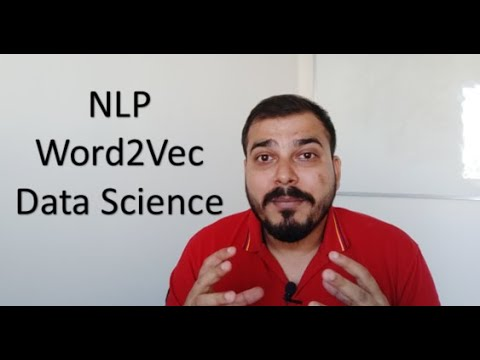

In [27]:
display_yotube_video("https://www.youtube.com/watch?v=Otde6VGvhWM")

# LSTM Peepholes architecture
![Image](LSTM_Peepholes.png)

# GRU Architecture 
![Image](GRU.png)